# 0 Preamble

## <span style="color: red;">0.0 Initialize Environment</span>
<span style="color: red;">Start Warning</span>

Run the following only if you need to **initialize** source data for the entire project environment.

In [ ]:
%run grabSource.py

Run the following only if you need to **overwrite** source data for the entire project environment.

In [ ]:
%run grabSource.py overwrite

<span style="color: red;">End Warning</span>

## 0.1 Global Packages

In [1]:
import pandas as pd
import warnings
import numpy as np
from sklearn import exceptions as skexceptions
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import matplotlib.pyplot as plt

## 0.2 Local Packages

## 0.3 Import Data

In [2]:
congressVotes_clean = pd.read_pickle('data/congressVotes_clean.pkl')
memberVotes_clean = pd.read_pickle('data/memberVotes_clean.pkl')

# 1 Preprocessing

## 1.1 Data Review

In [3]:
memberVotes_clean.head()

,congress,chamber,rollnumber,icpsr,cast_code,nominate_probability,vote_casting
15257230,101,House,1,633,1,99.9,Yay
15257231,101,House,1,1077,1,100.0,Yay
15257232,101,House,1,1087,6,99.2,Nay
15257233,101,House,1,2009,6,76.8,Nay
15257234,101,House,1,2605,1,100.0,Yay


In [4]:
congressVotes_clean.head()

,congress,chamber,rollnumber,date,yea_count,nay_count,nominate_mid_1,nominate_mid_2,nominate_spread_1,nominate_spread_2,nominate_log_likelihood,bill_number,vote_result,president_party
0,101,House,369,1990-01-24,312,89,0.295,-0.312,0.896,-2.289,-96.321,NaN,Passed,Republican
1,101,House,370,1990-01-24,137,276,0.104,0.950,-0.291,-0.081,-80.505,HR2712,Failed,Republican
2,101,House,371,1990-01-24,390,25,0.210,0.978,0.147,0.365,-82.013,HR2712,Passed,Republican
3,101,House,372,1990-01-31,301,100,0.392,-0.044,0.236,-0.636,-97.717,NaN,Passed,Republican
4,101,House,373,1990-01-31,254,166,0.060,-0.192,0.284,-0.398,-40.823,HRES309,Passed,Republican


## 1.2 Filtering

Reducing Congress set to bills to reduce overlapping factors on lesser-actioned and administrative actions of each Congressional body.

In [5]:
congressVotes_subset = congressVotes_clean[congressVotes_clean.bill_number.notna()]

In [6]:
data = pd.merge(
    memberVotes_clean,
    congressVotes_subset,
    how= 'inner',
    left_on= ['congress', 'chamber', 'rollnumber'],
    right_on= ['congress', 'chamber', 'rollnumber']
)

data.shape

(7423216, 18)

In [7]:
data.head()

,congress,chamber,rollnumber,icpsr,cast_code,nominate_probability,vote_casting,date,yea_count,nay_count,nominate_mid_1,nominate_mid_2,nominate_spread_1,nominate_spread_2,nominate_log_likelihood,bill_number,vote_result,president_party
0,101,House,370,633,6,95.2,Nay,1990-01-24,137,276,0.104,0.95,-0.291,-0.081,-80.505,HR2712,Failed,Republican
1,101,House,370,1077,6,100.0,Nay,1990-01-24,137,276,0.104,0.95,-0.291,-0.081,-80.505,HR2712,Failed,Republican
2,101,House,370,1087,1,65.1,Yay,1990-01-24,137,276,0.104,0.95,-0.291,-0.081,-80.505,HR2712,Failed,Republican
3,101,House,370,2009,6,85.6,Nay,1990-01-24,137,276,0.104,0.95,-0.291,-0.081,-80.505,HR2712,Failed,Republican
4,101,House,370,2605,6,100.0,Nay,1990-01-24,137,276,0.104,0.95,-0.291,-0.081,-80.505,HR2712,Failed,Republican


## 1.3 Grouping

Modeling is grouped by individual members; collecting vote counts for potential accuracy thresholds of models.

In [8]:
members = data.groupby('icpsr')['vote_casting'].count()
members.name = 'vote_pool'
members.sort_values(inplace= True)

## 1.4 Feature Processing

`vote_result` shifted to boolean as `1 = Passed` and `0 = Failed`

`vote_casting` shifted to boolean as `1 = Yay` and `0 = Nay`

`president_party` shifted to boolean as `1 = Republican` and `0 = Democrat`

In [9]:
data['vote_result_code'] = data['vote_result'].apply(
    lambda x: 1 if x == 'Passed' else 0
)
data['vote_casting_code'] = data['vote_casting'].apply(
    lambda x: 1 if x == 'Yay' else 0
)
data['president_party_code'] = data['president_party'].apply(
    lambda x: 1 if x == 'Republican' else 0
)

data.head()

,congress,chamber,rollnumber,icpsr,cast_code,nominate_probability,vote_casting,date,yea_count,nay_count,...,nominate_mid_2,nominate_spread_1,nominate_spread_2,nominate_log_likelihood,bill_number,vote_result,president_party,vote_result_code,vote_casting_code,president_party_code
0,101,House,370,633,6,95.2,Nay,1990-01-24,137,276,...,0.95,-0.291,-0.081,-80.505,HR2712,Failed,Republican,0,0,1
1,101,House,370,1077,6,100.0,Nay,1990-01-24,137,276,...,0.95,-0.291,-0.081,-80.505,HR2712,Failed,Republican,0,0,1
2,101,House,370,1087,1,65.1,Yay,1990-01-24,137,276,...,0.95,-0.291,-0.081,-80.505,HR2712,Failed,Republican,0,1,1
3,101,House,370,2009,6,85.6,Nay,1990-01-24,137,276,...,0.95,-0.291,-0.081,-80.505,HR2712,Failed,Republican,0,0,1
4,101,House,370,2605,6,100.0,Nay,1990-01-24,137,276,...,0.95,-0.291,-0.081,-80.505,HR2712,Failed,Republican,0,0,1


## 1.5 Independent Dimensions

Reducing dataset to model independent and dependent dimensions.

In [10]:
data_processed = data[['icpsr', 'date', 'nominate_mid_1', 'nominate_spread_1', 'nominate_log_likelihood', 'president_party_code', 'vote_casting_code', 'vote_result_code']].copy()
data_processed.sort_values(['icpsr', 'date'], inplace= True)

# 2 Modeling

## 2.1 Local Functions

In [11]:
def logitmodel_Member(data:pd.DataFrame, model):
    '''
    Iterating model builder for DataFrame inputs.

    Arguments:
         data: (DataFrame) Input dataset.
        model: (sklearn.Model) Applied categorical model; current functionality only
               works in LogisticRegression and RandomForestClassifier objects.

    Returns:
        (dict) Summary results of the model.
    '''
    # local variables
    trows = len(data)
    a, b = int(.7 * trows), int(.9 * trows)

    # train, validate, test
    df_train = data.iloc[:a]
    X_train = df_train.drop(columns= ['date', 'vote_result_code'])
    Y_train = df_train['vote_result_code']
    df_validate = data.iloc[a:b]
    X_validate = df_validate.drop(columns= ['date', 'vote_result_code'])
    Y_validate = df_validate['vote_result_code']
    df_test = data.iloc[b:]
    X_test = df_test.drop(columns= ['date', 'vote_result_code'])
    Y_test = df_test['vote_result_code']

    try:
        # convergence catching
        with warnings.catch_warnings():
            warnings.filterwarnings("error", category= skexceptions.ConvergenceWarning)
            warnings.filterwarnings("error", category= skexceptions.UndefinedMetricWarning)

            # initial modeling
            model.fit(X_train, Y_train)

            # add predictions
            Y_valpreds = model.predict(X_validate)
            Y_testpreds = model.predict(X_test)
            Y_testprobs = model.predict_proba(X_test)

            # classification reports
            report_validate = classification_report(Y_validate, Y_valpreds, output_dict= True)
            report_test = classification_report(Y_test, Y_testpreds, output_dict= True)

            # build results dataframe
            dict_result = {
                'val_accuracy': accuracy_score(Y_validate, Y_valpreds),
                'val_true_precision': report_validate['1']['precision'],
                'val_true_recall': report_validate['1']['recall'],
                'test_accuracy': accuracy_score(Y_test, Y_testpreds),
                'test_true_precision': report_test['1']['precision'],
                'test_true_recall': report_test['1']['recall'],
                'test_actual_values': Y_test,
                'test_prediction_values': Y_testpreds,
                'test_prediction_probs': Y_testprobs
            }
            
            return dict_result
    
    except (ValueError, KeyError):
        # catching for models with insufficient info to compile model aspects
        return
    
    except (skexceptions.ConvergenceWarning, skexceptions.UndefinedMetricWarning):
        # dealing with models that cannot complete due to convergence of racked info
        return

## 2.2 Apply Model

In [12]:
rf_results = []
lr_results = []
for _, m in enumerate(members.index):
    grouping = {
        'icpsr': m,
        'vote_pool': members[m]
    }
    df = data_processed[data_processed['icpsr'] == m]
    # random forest
    model_results = logitmodel_Member(df, RandomForestClassifier())
    if model_results:
        rf_results.append({**grouping, **model_results})
    else:
        rf_results.append(grouping)

    # logistic regression
    model_results = logitmodel_Member(df, LogisticRegression(max_iter= 200))
    if model_results:
        lr_results.append({**grouping, **model_results})
    else:
        lr_results.append(grouping)
    

In [13]:
df_rf = pd.DataFrame(rf_results)
df_lr = pd.DataFrame(lr_results)

## 2.3 Strata Tables

In [14]:

df_lr_vote = df_lr.copy()
df_lr_vote['vote_pool_bin'] = np.floor(df_lr_vote['vote_pool'] / 100).astype(int)
df_lr_vote = df_lr_vote.groupby('vote_pool_bin')['test_accuracy'].agg(['mean', 'std', 'min', 'max'])
df_lr_vote = df_lr_vote.dropna()

In [15]:
df_rf_vote = df_rf.copy()
df_rf_vote['vote_pool_bin'] = np.floor(df_rf_vote['vote_pool'] / 100).astype(int)
df_rf_vote = df_rf_vote.groupby('vote_pool_bin')['test_accuracy'].agg(['mean', 'std', 'min', 'max'])
df_rf_vote = df_rf_vote.dropna()

# 3 Model Results

## 3.1 Logistic Regression

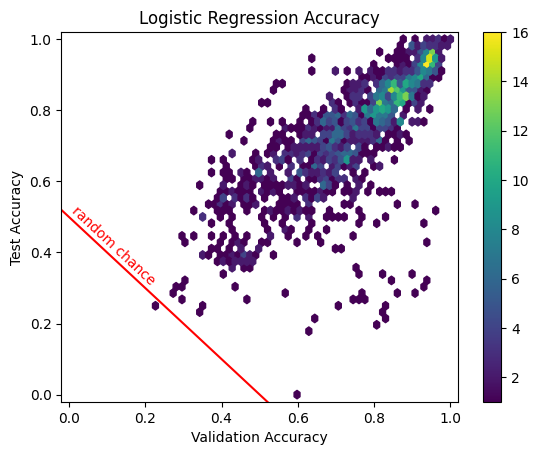

In [16]:
x = np.linspace(-1, 1, 100)
plt.hexbin(
    df_lr['val_accuracy'],
    df_lr['test_accuracy'],
    gridsize= 50,
    cmap='viridis',
    mincnt= 1
)
plt.plot(x, -x + .5, color= 'red')
plt.xlim(-.02, 1.02)
plt.ylim(-.02, 1.02)
plt.text(0, .42, 'random chance', rotation= -43, ha= 'left', va= 'center', color= 'red')

plt.colorbar()
plt.xlabel('Validation Accuracy')
plt.ylabel('Test Accuracy')
plt.title('Logistic Regression Accuracy')
plt.show()

## 3.2 Random Forest

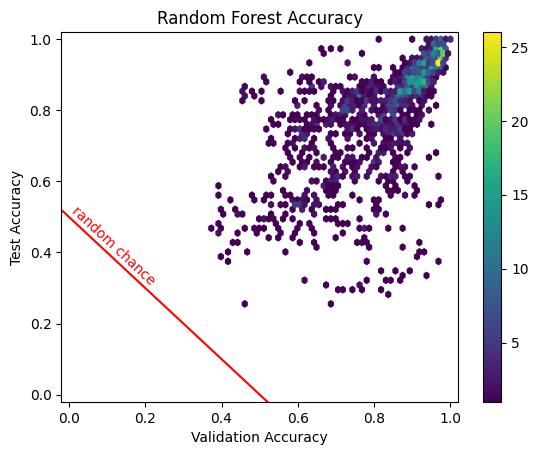

In [17]:
x = np.linspace(-1, 1, 100)
plt.hexbin(
    df_rf['val_accuracy'],
    df_rf['test_accuracy'],
    gridsize= 50,
    cmap='viridis',
    mincnt= 1)
plt.plot(x, -x + .5, color= 'red')
plt.xlim(-.02, 1.02)
plt.ylim(-.02, 1.02)
plt.text(0, .42, 'random chance', rotation= -43, ha= 'left', va= 'center', color= 'red')

plt.colorbar()
plt.xlabel('Validation Accuracy')
plt.ylabel('Test Accuracy')
plt.title('Random Forest Accuracy')
plt.show()

The dispersal variance of the Random Forrest accuracies suggests a weaker model. This is expected because the Logistic Regression has a stronger ability to handle log-loss and is often considered the default calibration for classification systems.

## 3.3 Trending Attributes

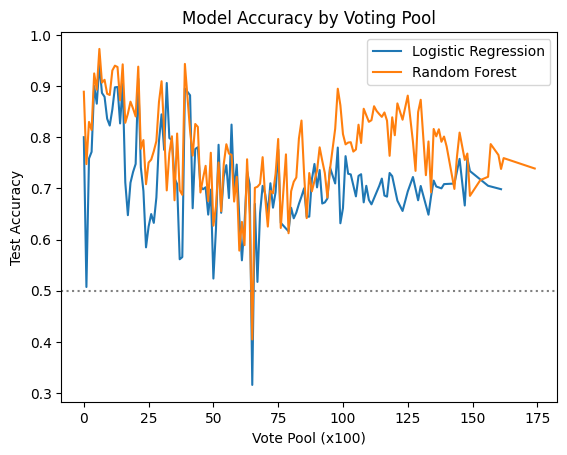

In [18]:
plt.plot(df_lr_vote.index, df_lr_vote['mean'], label= 'Logistic Regression')
plt.plot(df_rf_vote.index, df_rf_vote['mean'], label= 'Random Forest')
plt.axhline(0.5, color= 'gray', linestyle= 'dotted')
plt.xlabel('Vote Pool (x100)')
plt.ylabel('Test Accuracy')
plt.title('Model Accuracy by Voting Pool')

plt.legend()
plt.show()

With the exception of a few outliers, the prediction model is reasonably sufficient, however does not appear to create a pattern of accuracy given the number of votes the memebr has as part of the training set.